In [1]:
# Load Dependencies
import matplotlib.pyplot as plt

import torch

import pyro
import numpy as np
import pyro.distributions as dist
from pyro.poutine import trace, replay, block
from pyro.infer.autoguide.guides import AutoDelta, AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
# from pyro.optim import Adam

import sys
sys.path.append("../")

from pyciemss.utils import run_inference, get_tspan

import warnings
warnings.filterwarnings('ignore')

/Users/sam-basis/opt/anaconda3/envs/askem-test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Plotting Utilities

def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time /days')
    ax.set_ylabel('Infected (1000s)')
    return ax

def plot_predictive(prediction, tspan, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):
    vars = ["I_obs"]
    
    I_low = torch.quantile(prediction["I_obs"], 0.05, dim=0).detach().numpy()/1000
    I_up = torch.quantile(prediction["I_obs"], 0.95, dim=0).detach().numpy()/1000

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data["I_obs"].squeeze().detach().numpy()/1000., color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

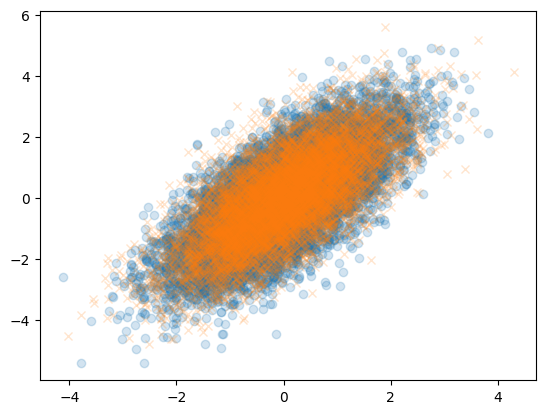

In [36]:
import pyro
import torch

def model7():
            x = pyro.sample("x", pyro.distributions.Normal(0, 1))
            y = pyro.sample("y", pyro.distributions.Normal(x, 1))
            return y

def model8():
            x = pyro.sample("x", pyro.distributions.Normal(0, 1))
            y = pyro.sample("y", pyro.distributions.Normal(0, torch.sqrt(torch.tensor([2]))))
            return y

def model9():
    y = pyro.sample("y", pyro.distributions.Normal(0., torch.sqrt(torch.tensor([2]))))
    x = pyro.sample("x", pyro.distributions.Normal(y/2, torch.sqrt(torch.tensor([2]))/2))
    return x, y

def model10():
    x = pyro.sample("x", pyro.distributions.Normal(0, 1.01))
    y = pyro.sample("y", pyro.distributions.Normal(x, 1))
    return x, y

with pyro.plate("plate", 10000, dim=-1):
    x, y = model9()
    x_, y_ = model10()


import matplotlib.pyplot as plt

plt.plot(x.detach().numpy(), y.detach().numpy(), 'o', alpha=0.2)
plt.plot(x_.detach().numpy(), y_.detach().numpy(), 'x', alpha=0.2)

In [37]:
from pyro.infer import  Trace_ELBO
import numpy as np
elbo = Trace_ELBO(num_particles= 1000, vectorize_particles=False)
elbo.loss(model7, model8), elbo.loss(model8,model7)

(0.6535738073587413, 0.4043467864990233)

In [31]:
# Setup Parameters

observed_tspan = get_tspan(1, 7, 7)
new_tspan = get_tspan(7, 89, 83)
full_tspan = get_tspan(1, 89, 89)

num_samples = 500

# Total population, N.
N = 100000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0., 81.0, 0., 0.
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

# 18 - 24 year olds
I_obs = torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])

initial_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I0, Iv0, R0))
final_observed_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I_obs[-1], Iv0, R0))


NameError: name 'get_tspan' is not defined

# Probabilistic Forecasting - Ignoring Historical Data

In [4]:
from pyciemss.ODE.models import SVIIvR

In [5]:
pyro.set_rng_seed(0)

noisy_ode_model = SVIIvR(N, 
                noise_prior=dist.Uniform(5., 10.),
                beta_prior=dist.Uniform(0.1, 0.3), 
                betaV_prior=dist.Uniform(0.025, 0.05),
                gamma_prior=dist.Uniform(0.05, 0.35),
                gammaV_prior=dist.Uniform(0.1, 0.4),
                nu_prior=dist.Uniform(0.001, 0.01))

In [6]:

ode_model = pyro.do(noisy_ode_model, {"noise_var": torch.tensor([0.000001])})

## Q: "What likely future outcomes does our model imply?"

In [7]:
prior_prediction = Predictive(ode_model, num_samples=num_samples)(initial_state, full_tspan)
single_prediction = Predictive(ode_model, num_samples=1)(initial_state, full_tspan)

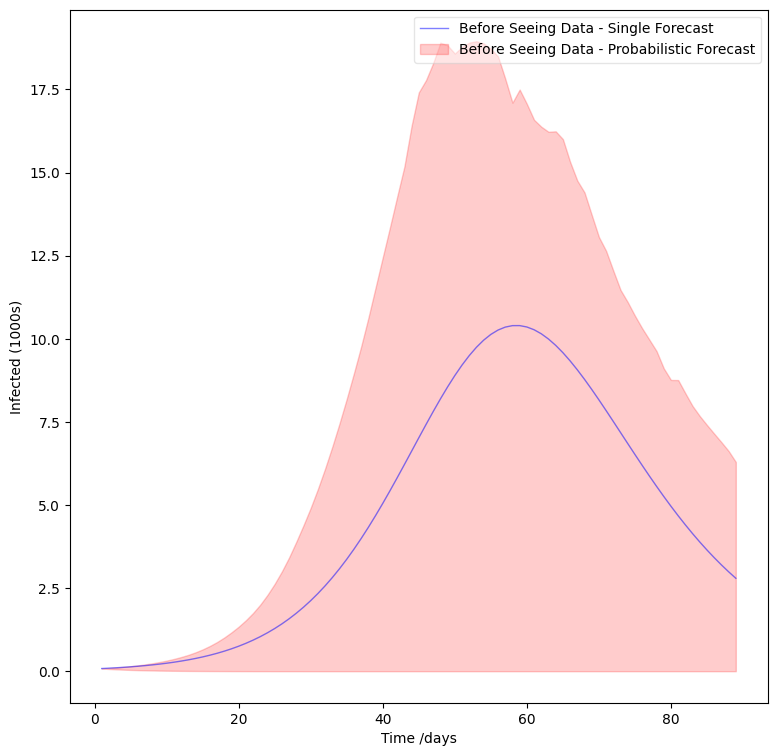

In [8]:

ax = plot_trajectory(single_prediction, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")

## Forecasting - Incorporating Historical Data

In [9]:
pyro.set_rng_seed(0)

guide = AutoNormal(block(noisy_ode_model, hide=["S_obs", "V_obs", "R_obs"]))
map_guide = AutoDelta(block(noisy_ode_model, hide=["S_obs", "V_obs", "R_obs"]))

data = {"S_obs":None, "V_obs":None, "I_obs":I_obs, "R_obs":None}

run_inference(noisy_ode_model, guide, initial_state, observed_tspan, data, num_iterations=200, verbose=False)
run_inference(noisy_ode_model, map_guide, initial_state, observed_tspan, data, num_iterations=200, verbose=False)

map_prediction = Predictive(ode_model, guide=map_guide, num_samples=1)(final_observed_state, new_tspan)
posterior_prediction = Predictive(ode_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

## Q: "What future outcomes are likely given the data we've seen?"

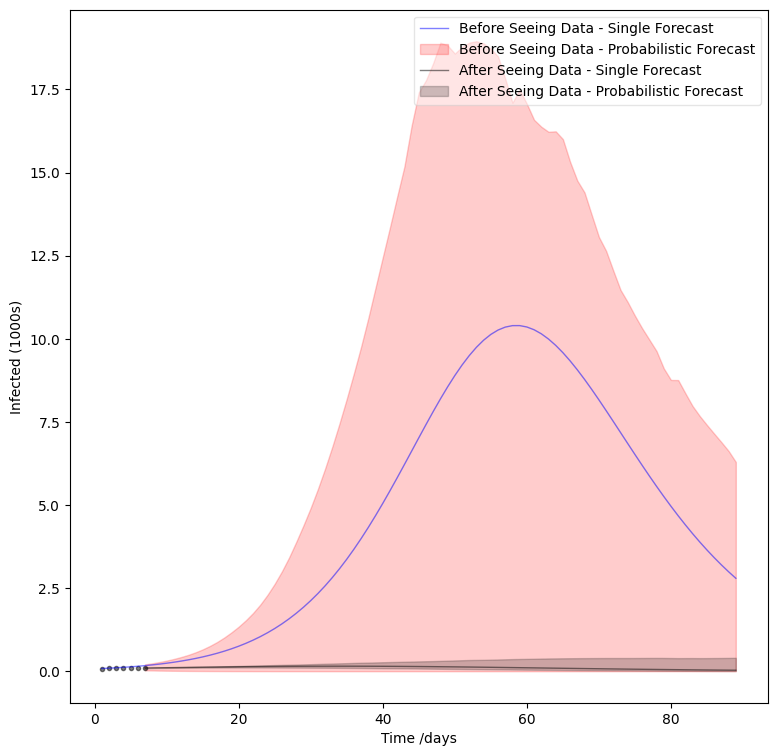

In [10]:

ax = plot_trajectory(data, observed_tspan, ax=setup_ax())
ax = plot_trajectory(single_prediction, full_tspan, ax=ax, color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, full_tspan, tmin=7, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax = plot_trajectory(map_prediction, new_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")

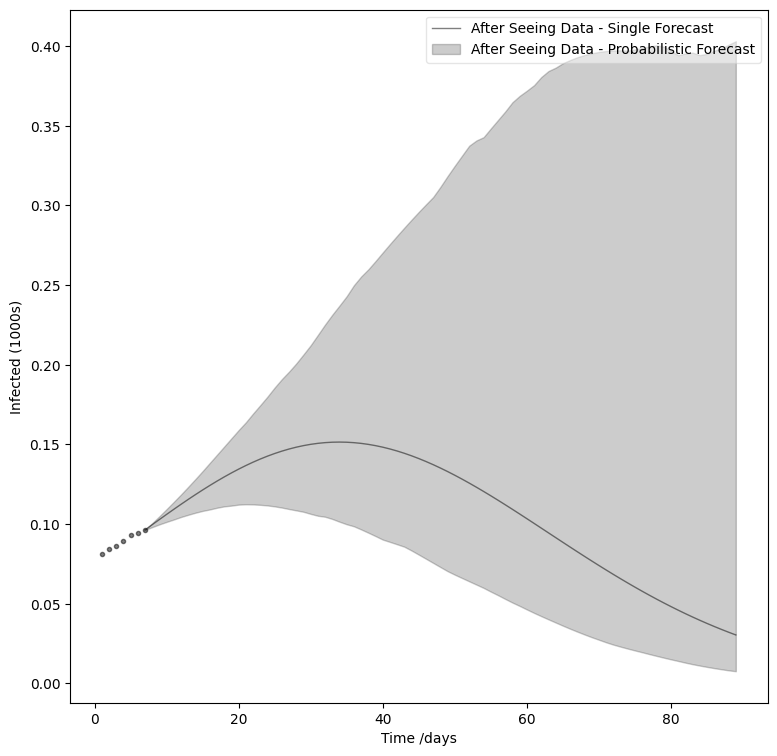

In [11]:

ax = plot_trajectory(data, observed_tspan, ax=setup_ax())
ax = plot_trajectory(map_prediction, new_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")

# Probabilistic Forecasting - Exploring Possible Interventions

In [12]:
from causal_pyro.query.do_messenger import do
from pyciemss.ODE.interventions import constant_intervention, time_dependent_intervention, state_dependent_intervention, parameter_intervention

## Q: "What would happen if we set the vaccination rate parameter, $\nu$?"

In [13]:
pyro.set_rng_seed(0)

rate_parameter_intervention = parameter_intervention("nu", torch.tensor([0.01]))
intervened_parameter_model = do(ode_model, rate_parameter_intervention)
intervened_parameter_prediction = Predictive(intervened_parameter_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We can't change the rate parameter directly. Bring me another policy!"
## Q: "What would happen if we set the vaccination rate to a constant 500 people per day?"

In [ ]:
pyro.set_rng_seed(0)

rate_intervention = constant_intervention("SV_flux", torch.tensor([500.]), full_tspan)
rate_intervention_model = do(ode_model, rate_intervention)
rate_intervention_prediction = Predictive(rate_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, ax=ax, color='blue', label="Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We have a lot more vaccines than that, but they aren't available yet!"
## Q: "What would happen if we set the vaccination rate to 500 people per day for the first month, then 750, then 1000?"

In [ ]:
pyro.set_rng_seed(0)

def ramping_rate_up_intervention_function(t):
    month = torch.floor(t / 30.).int()
    return torch.tensor([500.0, 750.0, 1000.])[month]

ramping_rate_up_intervention = time_dependent_intervention("SV_flux", ramping_rate_up_intervention_function, new_tspan)
ramping_rate_up_intervention_model = do(ode_model, ramping_rate_up_intervention)
ramping_rate_up_intervention_prediction = Predictive(ramping_rate_up_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(ramping_rate_up_intervention_prediction, new_tspan, ax=ax, color='green', label="Ramping Up Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We can't force people to take a vaccine. Let's run a marketing campaign to encourage vaccination!"
## Q: "What would happen if the marketing campaign convinces 500 **more** people per day to get vaccinated than without it?"

In [ ]:
pyro.set_rng_seed(0)

def vaccination_encouragement_intervention_function(SV_flux):
    return SV_flux + torch.tensor([500.])

vaccination_encouragement_intervention = state_dependent_intervention("SV_flux", vaccination_encouragement_intervention_function, new_tspan)
vaccination_encouragement_intervention_model = do(ode_model, vaccination_encouragement_intervention)
vaccination_encouragement_intervention_prediction = Predictive(vaccination_encouragement_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, color='black', label="No Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, ax=ax, color='purple', label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)

In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, color='black', ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, hatch='.', edgecolor="red", linewidth=2.5, facecolor="none", ax=ax, alpha=0.3, label="Vaccination Rate Parameter Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, hatch='/', ax=ax, alpha=0.3, linewidth=2.5, edgecolor='blue', facecolor="none", label="Vaccination Rate Intervention")
ax = plot_predictive(ramping_rate_up_intervention_prediction, new_tspan, hatch='..', linewidth=3, ax=ax, alpha=0.3, edgecolor='green', facecolor="none", label="Ramping Up Vaccination Rate Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, hatch="\\", linewidth=2.5, ax=ax, alpha=0.3, edgecolor='black', facecolor="none", label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "Let's only market to young people!"
## Q: "What would happen if the marketing campaign convinces 500 more people age 18-24 per day to get vaccinated than without it?"

In [ ]:
pyro.set_rng_seed(0)

stratified_intervention = state_dependent_intervention("SV_flux_18-24", vaccination_encouragement_intervention_function, new_tspan)
stratified_intervention_model = do(ode_model, stratified_intervention)

In [ ]:

import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

raise ValueError("The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24").with_traceback(None) from None

In [ ]:



# # (experimental conditions, replicates, attributes, timesteps,)
# data_cube = torch.zeros((5, 500, 4, 83))

# for i, var in enumerate(["S_obs", "V_obs", "I_obs", "R_obs"]):
#     for j, prediction in enumerate([posterior_prediction, intervened_parameter_prediction, rate_intervention_prediction, ramping_rate_up_intervention_prediction, vaccination_encouragement_intervention_prediction]):
#         data_cube[j, :, i, :] = prediction[var]

# data_cube = data_cube.detach().numpy()

# import numpy as np
# import pickle

# np.save("datacube.npy", data_cube)

# d = {"experimental conditions":["no_intervention", "intervened_parameter", "intervened_rate", "ramping_intervention", "encouragement_interventions"],
#     "replicates": [i for i in range(500)],
#      "attributes":["S", "V", "I", "R"],
#      "timesteps": [i.detach().item() for i in new_tspan]}

# with open("dimensions.pkl", 'wb') as f:
#     pickle.dump(d, f)


# Risk-based optimization under uncertainty
## Q: "What is the minimal vaccination policy that results in less than 10 infected individuals after 90 days?"

### Problem Formulation
* **Quantity of interest**: 7-day average of total infections after 90 days
    $$M(\boldsymbol{u}, \theta) = \frac{1}{7}\sum_{i=0}^6 I(t=90-i;\boldsymbol{u},\theta)+I_\text{V}(t=90-i;\boldsymbol{u},\theta)$$

* **Control**: $\boldsymbol{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Vaccination rate parameter: $u=\nu$
    * Scheduled intervention changing SV_flux over each month: $\boldsymbol{u} \in \mathbb{R}^3$
    * Other practical policies as interventions



* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the vaccination rate.
    * Constraint - Risk of infections exceeding the prescribed threshold of 10, $\mathcal{R}( M(\boldsymbol{u}, \theta))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\boldsymbol{u}^*= \underset{\boldsymbol{u}\in\mathcal{U}}{\arg\min}\ & \lVert \boldsymbol{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\boldsymbol{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

## Comparing risk measures

![table_risk.png](figures/table_risk.png)

#### Adavantages of using alpha-superquantile
* Considers magnitude of infections exceeding the threshold:
    * Overcome limitations of hard thresholding
    * Desirable data-informed conservativeness
* Preserves properties of underlying quantities of interest, such as convexity

In [ ]:

import os
import time
import pickle
import numpy as np
from scipy import stats
from matplotlib import ticker

from CIEMSS.digitaltwin import ODETwin, ODEState
from CIEMSS.control import Control_pyro
from CIEMSS.control.risk_ouu_pyro import OptProblem
from CIEMSS.control.risk_measures import Risk

def decision_metric_samples(I, Iv=None, tf=90, metric='infections', ndays=7, dt=1.):
    # returns distribution of ndays average of total infections at given time tf
    if metric == 'infections':
        # Estimate n-day average of cases
        if Iv is None:
            I_ndays = I[:,int(tf/dt)-ndays+1:int(tf/dt)+1]
            samples = np.mean(I_ndays,axis=1)
            samp = samples
        else:
            I_ndays = I[:,int(tf/dt)-ndays+1:int(tf/dt)+1]
            Iv_ndays = Iv[:,int(tf/dt)-ndays+1:int(tf/dt)+1]
            samples = np.mean(I_ndays + Iv_ndays,axis=1)
            samp = samples

    return samples

####### optimizer inputs
decision_metric = 'infections'
tf = 90
N_SAMPLES=int(1e3)
maxfeval=50
maxiter=5

### ODE
twin = ODETwin()
twin.forward = SVIIvR

In [ ]:
# Estimate risk for a given control of scheduled vaccination flux over each of the three months
twin.control = Control_pyro().scheduled_vaccination([10., 5., 10.])
outputs_MC_sv, _, t = twin.forwardUQsv_pyro(num_samples=N_SAMPLES, tf=tf, rseed=1)

# Get samples of 7-day average infections
Itotal_samples_sv = decision_metric_samples(outputs_MC_sv['Itot'], tf=tf, metric='infections', dt=1.)

# Estimate risk
qbarval_sv = getattr(Risk(Itotal_samples_sv),'alpha_superquantile')(0.95)
qval_sv = getattr(Risk(Itotal_samples_sv),'alpha_quantile')(0.95)


In [ ]:

fig1 = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(Itotal_samples_sv, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(qval, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(qbarval, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', usetex=True, size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.close()


![Query2_infections_SVflux_vrate005_90days_hist.png](figures/Query2_infections_SVflux_vrate005_90days_hist.png)

## Risk-based optimization under uncertainty with different interventions

In [ ]:
# Set up optimization problem with alpha-quantile
risk_measures='alpha_quantile'
risk_params=0.95
jj=0
print('Performing risk-based OUU...')
optprob = OptProblem(twin, decision_metric='infections', risk_measure=risk_measure, risk_params=risk_params, 
                     t0=0, tf=90, u_bounds=np.array([0., 1e4]), num_samples=N_SAMPLES, maxfeval=maxfeval, 
                     maxiter=maxiter, guide=guide, control_name='svflux')

##### Minimizing vaccination for constraint on risk
risk_bound = 10.
risk_res[jj] = optprob.solve_minvrate(risk_bound=risk_bound)

In [ ]:
# Set up optimization problem with alpha-superquantile
risk_measures='alpha_superquantile'
risk_params=0.95
jj=1
optprob = OptProblem(twin, decision_metric='infections', risk_measure=risk_measure, risk_params=risk_params, 
                     t0=0, tf=90, u_bounds=np.array([0., 1e4]), num_samples=N_SAMPLES, maxfeval=maxfeval, 
                     maxiter=maxiter, guide=guide, control_name='svflux')

##### Minimizing vaccination for constraint on risk
risk_bound = 10.
risk_res[jj] = optprob.solve_minvrate(risk_bound=risk_bound)

**Optimal decision using interventation on vaccination rate parameter**

![Query2_infections_nu_infectionsdist_ouu.png](figures/Query2_infections_nu_infectionsdist_ouu.png) ![table_ouu.png](figures/table_ouu.png) 


**Optimal decision using scheduled interventation over 3 months**

![Query2_infections_SVflux_inithigh_infectionsdist_ouu.png](figures/Query2_infections_SVflux_inithigh_infectionsdist_ouu.png)